# DATA PREPROCESSING, FEATURE ENGINEERING  
# And MODEL COMPARISION

## W207 ML Final Project - Kaggle Forest Cover Prediction
Our team (Team-06) comprises of **Tymov, Savita, Blake and Andrew**. We have decided to predict the Forest cover type probelem proposed by Kaggle (https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset) In this project we will be predicting the type of trees that cover based on the existing data collected in the forests in Roosevelt National Forest in Northeren Colorado. The data is based on 30 x 30 meter cell. The USA Forest Service (USFS) Region 2 has collected this data with the help of USA Geological Survey. 

The dataset has more than half a million rows and includes information on tree type, shadow coverage, distance to nearby landmarks (roads etcetera), soil type, and local topography 



## Question we are trying to answer
###### Can we build a model that predicts what types of trees grow in an area based on the surrounding characteristics? 
###### What kinds of trees are most common in the Roosevelt National Forest?
###### What tree types are confused most ?

## Data Processing And EDA

### SETUP
<hr>

In [9]:
import pandas as pd
import numpy as np
import random 
import itertools 
from zipfile import ZipFile, Path

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

%matplotlib inline

### GET DATA
<hr>

In [10]:
def get_data():
    with ZipFile("covtype.zip") as myzip:
        data = myzip.open("covtype.csv")
        df = pd.read_csv(data)

    return df

In [11]:
def reverse_encode(relevant_subset):
    '''
    This function reverses one-hot encoding for into rank-encoded representations
    Parameters: an subset of relevant columns of the same type, which we are trying to reverse encode
    Output: a title-less list of the encoded variable in numerical data
    '''

    num_list =[]
    for i in relevant_subset.iloc:
        ix = 1
        for j in i:
            if j ==1:
                num_list.append(ix)
            else: 
                ix +=1
                
    print('The new list has the following elements: ' + str(set(num_list)))
    if relevant_subset.shape[0] == len(num_list):
        return num_list
    else: print('Error in compiling list: lengths of the two lists do not match.')

In [12]:
tree_df = get_data() # instantiate are tree datafrime
soil_df = tree_df.loc[:,'Soil_Type1':'Soil_Type40'] # define our soul subset dataframe
wilderness_df = tree_df.loc[:,'Wilderness_Area1':'Wilderness_Area4'] # define our wilderness subset dataframe
cont_df = tree_df.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points'] # dataframe of remaining, continuous variables

In [13]:
# reverse one-hot-encode our soil and wilderness dataframes
w = reverse_encode(wilderness_df)
s = reverse_encode(soil_df)
# add our new features to the remaining, continuous varaiables dataframe
cont_df['Wilderness'] = w
cont_df['SoilType'] = s

forest_df = cont_df
#print(forest_df.head())

The new list has the following elements: {1, 2, 3, 4}
The new list has the following elements: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4           

C:\Users\savit\AppData\Local\Temp/ipykernel_16512/587112543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['Wilderness'] = w
C:\Users\savit\AppData\Local\Temp/ipykernel_16512/587112543.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['SoilType'] = s


In [14]:
# scale our data (subtract mean and divide by standard deviation)
X_forest = preprocessing.scale(forest_df.values)

# combine our data so that we can split into train, test, val
X_forest_df = pd.DataFrame(X_forest, columns=[forest_df.columns])
X_forest_df['cov_type'] = tree_df.values[:, -1]
XY_forest_df = X_forest_df
print(XY_forest_df.shape)

(581012, 13)


In [15]:
# - split to train, val, test (70, 20, 10)
train, remainder = train_test_split(XY_forest_df, train_size=0.7)
val, test = train_test_split(remainder, test_size=0.33)

print(train.shape)
print(val.shape)
print(test.shape)

(406708, 13)
(116783, 13)
(57521, 13)


In [ ]:
# convert each dataset to csv and compress
train.to_csv('../train.zip', compression = dict(method='zip', archive_name='train.csv'))
val.to_csv('../val.zip', compression = dict(method='zip', archive_name='val.csv'))
test.to_csv('../test.zip', compression = dict(method='zip', archive_name='test.csv'))

### FEATURE SELECTION
<hr>

##### Get our datasets

In [2]:
with ZipFile("../train.zip") as myzip:
    data = myzip.open("train.csv")
    train_df = pd.read_csv(data)
    train_df.drop(train_df.columns[0], axis = 1, inplace = True)
    
with ZipFile("../val.zip") as myzip:
    data = myzip.open("val.csv")
    val_df = pd.read_csv(data)
    val_df.drop(val_df.columns[0], axis = 1, inplace = True)

with ZipFile("../test.zip") as myzip:
    data = myzip.open("test.csv")
    test_df = pd.read_csv(data)
    test_df.drop(test_df.columns[0], axis = 1, inplace = True)
    

In [18]:
train1_data = train_df.values[:, :-1]
train1_labels  = train_df.values[:, -1]
dev1_data = val_df.values[:, :-1]
dev1_labels  = val_df.values[:, -1]
test1_data = test_df.values[:, :-1]
test1_labels  = test_df.values[:, -1]

In [19]:
print (train1_data.shape,dev1_data.shape  , test1_data.shape)

(406708, 12) (116783, 12) (57521, 12)


##### Build random forest to get list of feature importance

In [125]:
# make a random forest model
rf = RandomForestClassifier()
rf.fit(train1_data, train1_labels)
rf_pred = rf.predict(dev1_data)
rf_acc = accuracy_score(rf_pred, dev1_labels)

feat_rf = rf.feature_importances_
print("Our random forest classified {:0.2f}% of the of the trees correctly".format(rf_acc*100))


Our random forest classified 96.16% of the of the trees correctly


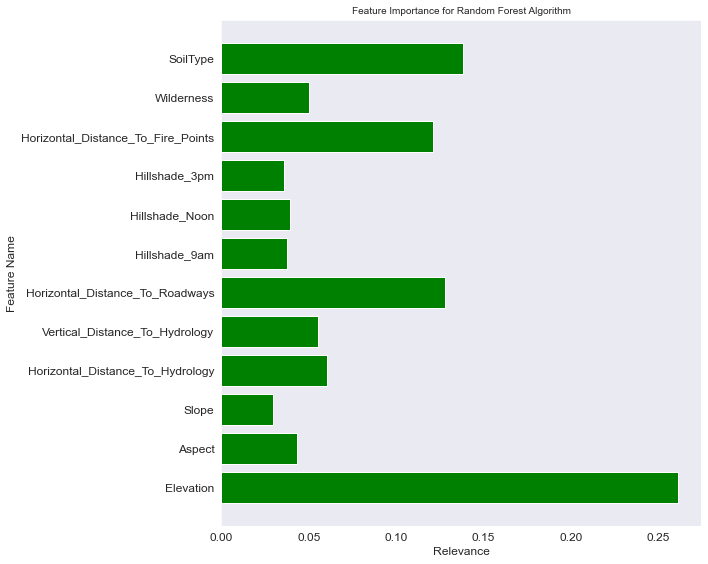

In [126]:
#plot feature importance
plt.figure(figsize=(10,8))
plt.barh(train_df.drop(columns='cov_type').columns.values, feat_rf, color='green')
plt.title('Feature Importance for Random Forest Algorithm',fontsize=10)
plt.ylabel('Feature Name')
plt.xlabel('Relevance')
plt.show()



#### A bar chart showing how important the random forest algorithm found the features in making predictions.

#### Finding Correlations between fields
##### Observations:


1. All fields are continuous or binary.
2. There are no string fields
3. Wilderness fields such as soil types are binary
###### The following fields are continuous
* Elevation
* Aspect
* Slope
* Horizont_Distance_To_Hydrology
* Vertical_Distance_To_Hydrology
* Horizontal_Distance_To_Roadway
* Hillshade_9am
* Hillshade_Noon
* Hillshade_3pm




###### Following is the correlation diagram between these fields

<AxesSubplot:xlabel='None', ylabel='None'>

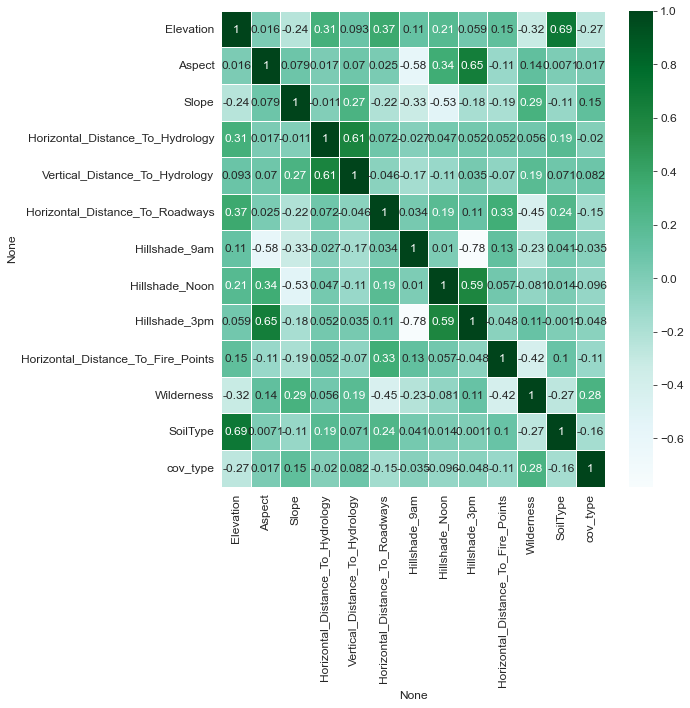

In [128]:
correlation = XY_forest_df.corr()

plt.figure(figsize=(10,10))

sns.heatmap(correlation,
            cmap='BuGn',
            linecolor='white',
            linewidths=1,
            annot=True, 
            xticklabels = True,
            yticklabels= True)


### FEATURE SELECTION RECOMMENDATIONS
<hr>

##### Check to see if model performance increased after feature selection

##### After removing the 'Aspect’ feature, the model increased to its accuracy by .40pp.

In [130]:
train_df2 = train_df.drop(columns='Hillshade_3pm')
val_df2 = val_df.drop(columns='Hillshade_3pm')
test_df2 = test_df.drop(columns='Hillshade_3pm')

train_data = train_df2.values[:, :-1]
train_labels  = train_df2.values[:, -1]
dev_data = val_df2.values[:, :-1]
dev_labels  = val_df2.values[:, -1]
test_data = test_df2.values[:, :-1]
test_labels  = test_df2.values[:, -1]

rf2 = RandomForestClassifier()
rf2.fit(train_data, train_labels)
rf_pred2 = rf2.predict(dev_data)
rf_acc2 = accuracy_score(rf_pred2, dev_labels)

print("Our random forest classified {:0.2f}% of the of the trees correctly".format(rf_acc2*100))

Our random forest classified 96.38% of the of the trees correctly


After removing the 'Hillshade_3pm’ feature, the model increased its accuracy by .18pp.

# Data processing
Once we  performing the EDA and cleanup of the data, we were ready for model building. 
We wanted to find out what was the best model that will work for our enormous data.
We examined several modelling approaches to uncover the best possibilities with our data

#### PreProcessing 
Based on the EDA, we observed that the scales on data points were very different.So we tried the followint preprocessing approaches to mitigate it.
* Scaling Techniques tried
    * **Standard Scaler** - Removes the mean and scaling. follows Standard Normal Distribution (SND). Therefore, it makes mean = 0 and scales the data to unit variance.
    * **MinMax Scaler** - scales all the data features in the range [0, 1] or else in the range [-1, 1] if there are negative values in the dataset
    * We also tries **Robust Scaler**, which removes the median and scales the data according to the quantile range, 
     but we did not see much benifit, so it is not part of our final report.
     
* We tried **dimentionality reduction** to see if it gives us any additional help in improving the predicibility. We used **Principal component analysis (PCA)** to simplify the complexity in our high-dimensional data so it would still retaining trends and patterns. PCA does this by transforming the data into fewer dimensions, which act as summaries of features.We experimented with the explained variance ratio and settled for 95% to select the principal components.

* We used **GridSearchCV** library function to helps us loop through predefined hyperparameters (using K-fold cross-validation) and fit your estimator on our training set, so that we could select the best parameters from the listed hyperparameters


#  Modeling Approach
In order to find the best model that suited our unique dataset, we tried several model building approached.
###### Models in the final document    
    1. KNeighborsClassifier
    2. LogisticRegression
    3. DecisionTreeClassifier
    4. RandomForestClassifier
    5. NeuralNetwork
    
#####  We tried all the models on same data to test and compare them on F1 score as well as how long it takes to build the model. 

##### After building our model on training data, we fit it on dev data. Finally we tested it on test data


In [28]:
model_df = pd.DataFrame()

##### Function for Dev and Test Prediction

In [33]:
# This is a function that generates ML Models of various types that we are interested in
# The Params are chosen based on experimentation we conducted earlier

def  ModelBuildAndScore(modelType = "KNeighborsClassifier",option = None, ):
    msg_txt = modelType
    global model_df
    if modelType== "KNeighborsClassifier":
            model = KNeighborsClassifier()
            grd_model = GridSearchCV( model ,  param_grid =  {'n_neighbors': [4]},return_train_score =  1, 
                                     cv=3, n_jobs=-1)
            
    elif modelType== "LogisticRegression":
            model = LogisticRegression()
            grd_model = GridSearchCV( LogisticRegression(max_iter=1000, random_state=1, solver='newton-cg', tol=0.001) ,  
                                     param_grid =  {'C': [0.1, 1.0, 100.0]},return_train_score =  1, cv=3, n_jobs=-1)

    elif modelType== "DecisionTreeClassifier":
            model = DecisionTreeClassifier()
            grd_model = GridSearchCV( DecisionTreeClassifier(random_state=1) ,  
                                     param_grid =  {'max_depth': [5, 15, 30, 50]},return_train_score =  1, cv=3, n_jobs=-1)

    elif modelType== "RandomForestClassifier":
            model = RandomForestClassifier()
            grd_model = model

    elif modelType== "NeuralNetwork":
            model = MLPClassifier(
                        hidden_layer_sizes = (54, 1024, 512, 256),
                        activation = 'relu',
                        solver = 'sgd',
                        batch_size = 512,
                        learning_rate = 'constant',
                        learning_rate_init = 0.1,
                        max_iter = 100,
                        momentum = 0.9,
                        shuffle = True,
                        verbose = True,
                        random_state = 26,
                        n_iter_no_change = 5,
                        tol = 0.001
                        )

            grd_model = model
            
    X_train = train_data
    X_dev = dev_data   
    X_test = test_data
    start = time. time()
    if modelType == "KNeighborsClassifier":
        if option == None:
            print("Creating model_df Dataframe")
            model_df = pd.DataFrame(columns =["model_name","model_type","time_taken","f1_score_dev",
                                              "f1_score_test","predicted_dev", "predicted_test"])
    if option == None:
        msg_txt += " With No Transformation "
        grd_model.fit(X_train,train_labels)
        predicted_dev = grd_model.predict(X_dev)
        predicted_test = grd_model.predict(X_test)
    elif option == "Scaler":
        msg_txt += " With Scaler_type 'MinMax' Transformation"
        print("scaler_type : MinMax")
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_dev = scaler.transform(X_dev)
        scaled_X_test = scaler.transform(X_test)
        grd_model.fit(scaled_X_train,train_labels)
        predicted_dev = grd_model.predict(scaled_X_dev)
        predicted_test= grd_model.predict(scaled_X_test)
    elif option == "PCA":
        msg_txt += " With PCA Transformation "
        var_threshold=0.95
        pca = PCA(n_components=X_train.shape[1])
        pca.fit(X_train)
        df_pca = pd.DataFrame()
        df_pca['NumPrinComponents'] = np.arange(start=1 , stop=X_train.shape[1])
        df_pca['ExplainedVariance'] = pd.Series(pca.explained_variance_ratio_)
        df_pca['CumExplainedVariance'] = pd.Series(np.cumsum(pca.explained_variance_ratio_))
        npca = df_pca.loc[df_pca.CumExplainedVariance > var_threshold,:].NumPrinComponents.iloc[0]
        pcaModel = PCA(n_components=npca)
        X_train_pca = pcaModel.fit_transform(X_train)
        X_dev_pca = pcaModel.transform(X_dev)
        X_test_pca = pcaModel.transform(X_test)
        grd_model.fit(X_train_pca,train_labels)
        predicted_dev = grd_model.predict(X_dev_pca)
        predicted_test = grd_model.predict(X_test_pca)
    end = time. time()
    duration = end - start
    print ( "\033[1m" ,   msg_txt , "\033[0;0m" )

    print ("Best fit model F1 score for Dev : ", metrics.f1_score(dev_labels, predicted_dev , average='micro'))
    print ("Best fit model F1 score for Test : ", metrics.f1_score(test_labels, predicted_test , average='micro'))

    print ("Duration : ", duration)
    print("Predicted_dev: ", predicted_dev)
    print("Predicted_dev Shape: ", predicted_dev.shape)
    print("Predicted_test: ", predicted_test)
    print("Predicted_test Shape: ", predicted_test.shape)

    # Update Dataframe 
    my_df = {"model_name": modelType, "model_type":  option, "time_taken": duration, 
             "f1_score_dev": metrics.f1_score(dev_labels, predicted_dev , average='micro'),
             "f1_score_test": metrics.f1_score(test_labels, predicted_test , average='micro'),
             "predicted_dev":predicted_dev, "predicted_test":predicted_test}
   
    model_df = model_df.append(my_df,ignore_index=True)
    #print(model_df)
    return model_df


In [119]:
print (train_data.shape,dev_data.shape, test_data.shape)

(406708, 11) (116783, 11) (57521, 11)


### Testing Multiple Classifiers
* The test ran 5 afore mentioned classifiers
    * Each classifier ran with wrangled data after EDA process 
    * Next, we used the dataset after Scaler-MinMax data transformations
    * We also used PCA for further dimentionality reduction
    * Some were run with K-fold cross-validation using GridSearchCV
* For each iteration meticulous data collection took place
    * For every iteration we collected F1 score for both dev dataset and test dataset
    * We timed every iteration
    * All the results including prediction was saved in a dataframe for further analysis
    * At the end of this test-run we had a combination of **15 models to compare** 
* Storing the data in dataframes gave us a lot of flexibility in gaining further insights
    * The data was processed in two ways
        * Accuracy - Based on the F1 Scores
        * Speed - Based on time taken to build the model
    * We generated Confusion Matrix of various combinations to understand the performance of the model
        * This was very useful in answering some of questions we had highlighted earlier
        * We compared some of the models to understand the errors being made by the model
    * We also generated Classification reports to measure the quality of the predictions from our models

In [34]:
import time 
total_start = time. time()
for classifier in ["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "NeuralNetwork"]:
    print("Classifier: ", classifier)
    for option in [None, "Scaler", "PCA"]:
        print("Option: ", option)
        df =   ModelBuildAndScore(modelType = classifier,option=option)
        print(df)
total_end = time. time()
print("Total Time Taken : ", total_end - total_start)


Classifier:  KNeighborsClassifier
Option:  None
Creating model_df Dataframe
 KNeighborsClassifier With No Transformation  
Best fit model F1 score for Dev :  0.9232508156152864
Best fit model F1 score for Test :  0.9229846490846821
Duration :  62.83980083465576
Predicted_dev:  [1. 1. 3. ... 1. 1. 1.]
Predicted_dev Shape:  (116783,)
Predicted_test:  [1. 2. 1. ... 7. 1. 6.]
Predicted_test Shape:  (57521,)
             model_name model_type  time_taken  f1_score_dev  f1_score_test  \
0  KNeighborsClassifier       None   62.839801      0.923251       0.922985   

                                       predicted_dev  \
0  [1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, ...   

                                      predicted_test  
0  [1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, ...  
Option:  Scaler
scaler_type : MinMax
 KNeighborsClassifier With Scaler_type 'MinMax' Transformation 
Best fit model F1 score for Dev :  0.9358982043619364
Best fit model F1 score for Test :  0.9353801220423845
D

 DecisionTreeClassifier With Scaler_type 'MinMax' Transformation 
Best fit model F1 score for Dev :  0.93428838101436
Best fit model F1 score for Test :  0.9325289894125625
Duration :  7.329729080200195
Predicted_dev:  [1. 2. 3. ... 1. 1. 1.]
Predicted_dev Shape:  (116783,)
Predicted_test:  [2. 2. 2. ... 7. 1. 6.]
Predicted_test Shape:  (57521,)
               model_name model_type  time_taken  f1_score_dev  f1_score_test  \
0    KNeighborsClassifier       None   62.839801      0.923251       0.922985   
1    KNeighborsClassifier     Scaler   68.542704      0.935898       0.935380   
2    KNeighborsClassifier        PCA   49.195306      0.916084       0.915961   
3      LogisticRegression       None  241.838542      0.713289       0.714852   
4      LogisticRegression     Scaler  234.497769      0.713263       0.714800   
5      LogisticRegression        PCA  263.004946      0.640204       0.640479   
6  DecisionTreeClassifier       None    7.511151      0.934194       0.932477   
7  D

 RandomForestClassifier With PCA Transformation  
Best fit model F1 score for Dev :  0.9280974114383087
Best fit model F1 score for Test :  0.9287738391196259
Duration :  128.01869654655457
Predicted_dev:  [1. 2. 3. ... 1. 1. 1.]
Predicted_dev Shape:  (116783,)
Predicted_test:  [2. 2. 1. ... 7. 1. 6.]
Predicted_test Shape:  (57521,)
                model_name model_type  time_taken  f1_score_dev  \
0     KNeighborsClassifier       None   62.839801      0.923251   
1     KNeighborsClassifier     Scaler   68.542704      0.935898   
2     KNeighborsClassifier        PCA   49.195306      0.916084   
3       LogisticRegression       None  241.838542      0.713289   
4       LogisticRegression     Scaler  234.497769      0.713263   
5       LogisticRegression        PCA  263.004946      0.640204   
6   DecisionTreeClassifier       None    7.511151      0.934194   
7   DecisionTreeClassifier     Scaler    7.329729      0.934288   
8   DecisionTreeClassifier        PCA   15.442532      0.85733

Iteration 1, loss = 0.76308671
Iteration 2, loss = 0.59833263
Iteration 3, loss = 0.51576960
Iteration 4, loss = 0.44675394
Iteration 5, loss = 0.39668846
Iteration 6, loss = 0.35599954
Iteration 7, loss = 0.32681736
Iteration 8, loss = 0.30274194
Iteration 9, loss = 0.28236790
Iteration 10, loss = 0.26550223
Iteration 11, loss = 0.25147662
Iteration 12, loss = 0.23991388
Iteration 13, loss = 0.22911813
Iteration 14, loss = 0.22117871
Iteration 15, loss = 0.21243382
Iteration 16, loss = 0.20443292
Iteration 17, loss = 0.19799338
Iteration 18, loss = 0.19275887
Iteration 19, loss = 0.18507052
Iteration 20, loss = 0.18015015
Iteration 21, loss = 0.17762014
Iteration 22, loss = 0.17167981
Iteration 23, loss = 0.16771432
Iteration 24, loss = 0.16434582
Iteration 25, loss = 0.16021413
Iteration 26, loss = 0.15690662
Iteration 27, loss = 0.15484397
Iteration 28, loss = 0.15158976
Iteration 29, loss = 0.14872797
Iteration 30, loss = 0.14652879
Iteration 31, loss = 0.14333207
Iteration 32, los

Iteration 54, loss = 0.07951733
Iteration 55, loss = 0.07763553
Iteration 56, loss = 0.07820796
Iteration 57, loss = 0.07580058
Iteration 58, loss = 0.07525784
Iteration 59, loss = 0.07484726
Iteration 60, loss = 0.07381170
Iteration 61, loss = 0.07238146
Iteration 62, loss = 0.07257531
Iteration 63, loss = 0.07193624
Iteration 64, loss = 0.07102702
Iteration 65, loss = 0.07020820
Iteration 66, loss = 0.06950709
Iteration 67, loss = 0.06924366
Training loss did not improve more than tol=0.001000 for 5 consecutive epochs. Stopping.
 NeuralNetwork With PCA Transformation  
Best fit model F1 score for Dev :  0.9516710480121251
Best fit model F1 score for Test :  0.9494097807757167
Duration :  19306.877322673798
Predicted_dev:  [1. 2. 3. ... 1. 1. 1.]
Predicted_dev Shape:  (116783,)
Predicted_test:  [2. 2. 1. ... 7. 7. 6.]
Predicted_test Shape:  (57521,)
                model_name model_type    time_taken  f1_score_dev  \
0     KNeighborsClassifier       None     62.839801      0.923251   

In [37]:
df.columns

Index(['model_name', 'model_type', 'time_taken', 'f1_score_dev',
       'f1_score_test', 'predicted_dev', 'predicted_test'],
      dtype='object')

In [38]:
print (df.shape)

(15, 7)


In [41]:
df_plot = df

In [42]:
# Create X axis Label that is a combination of Shortened Model Name and Model Type
def modelLabel(row):  
    if row['model_name'] == "RandomForestClassifier" and row['model_type'] == 'Scaler':
        return 'RandForest-Scaler'
    elif row['model_name'] == "RandomForestClassifier" and row['model_type'] is None:
        return 'RandForest'
    elif row['model_name'] == "KNeighborsClassifier" and row['model_type'] is None:
        return 'KNeighbor'
    elif row['model_name'] == "KNeighborsClassifier" and row['model_type'] == "PCA":
        return 'KNeighbor-PCA'
    elif row['model_name'] == "KNeighborsClassifier" and row['model_type'] == "Scaler":
        return 'KNeighbor-Scaler'
    elif row['model_name'] == "DecisionTreeClassifier" and row['model_type'] is None:
        return 'DecisionTree'
    elif row['model_name'] == "DecisionTreeClassifier" and row['model_type'] == "PCA":
        return 'DecisionTree-PCA'
    elif row['model_name'] == "DecisionTreeClassifier" and row['model_type'] == "Scaler":
        return 'DecisionTree-Scaler'
    elif row['model_name'] == "NeuralNetwork" and row['model_type'] is None:
        return 'NeuralNetwork'
    elif row['model_name'] == "NeuralNetwork" and row['model_type'] == "PCA":
        return 'NeuralNetwork-PCA'
    elif row['model_name'] == "NeuralNetwork" and row['model_type'] == "Scaler":
        return 'NeuralNetwork-Scaler'
    elif row['model_name'] == "LogisticRegression" and row['model_type'] is None:
        return 'LogisticRegression'
    elif row['model_name'] == "LogisticRegression" and row['model_type'] == "PCA":
        return 'LogisticRegression-PCA'
    elif row['model_name'] == "LogisticRegression" and row['model_type'] == "Scaler":
        return 'LogisticRegression-Scaler'


In [43]:
df_plot['xLabel'] = df_plot.apply(lambda row: modelLabel(row), axis=1)


In [44]:
df_plot.at[11,'xLabel']='RandForest-PCA'

In [45]:
df_sorted = df_plot.sort_values(by='f1_score_test', ascending=False)

In [46]:
print("\033[1m" ,"\t\t\tData Sorted on Test Score", "\033[0m" )
df_sorted[['xLabel','f1_score_dev','f1_score_test','time_taken']]

 			Data Sorted on Test Score 


,xLabel,f1_score_dev,f1_score_test,time_taken
9,RandForest,0.964096,0.964882,57.511182
10,RandForest-Scaler,0.963702,0.963857,57.112310
12,NeuralNetwork,0.958239,0.957946,2452.677204
13,NeuralNetwork-Scaler,0.954728,0.953582,4130.091561
14,NeuralNetwork-PCA,0.951671,0.949410,19306.877323
1,KNeighbor-Scaler,0.935898,0.935380,68.542704
7,DecisionTree-Scaler,0.934288,0.932529,7.329729
6,DecisionTree,0.934194,0.932477,7.511151
11,RandForest-PCA,0.928097,0.928774,128.018697
0,KNeighbor,0.923251,0.922985,62.839801


## Best Models
Several Models performed very well. 

### By F1 Score, Random Forest came on top with 97% accuracy, it took 57.5 sec to build
### The Random Forest Model bulit by us earlier had 96% accuracy


### By Time taken to build the model, DecisionTree with Scaler Transformation topped with 93% accuracy, it took 7.3 sec to build

In [60]:
plot_filtered = df_plot[~df_plot["xLabel"].isin( ["NeuralNetwork-PCA","NeuralNetwork-Scaler"])]

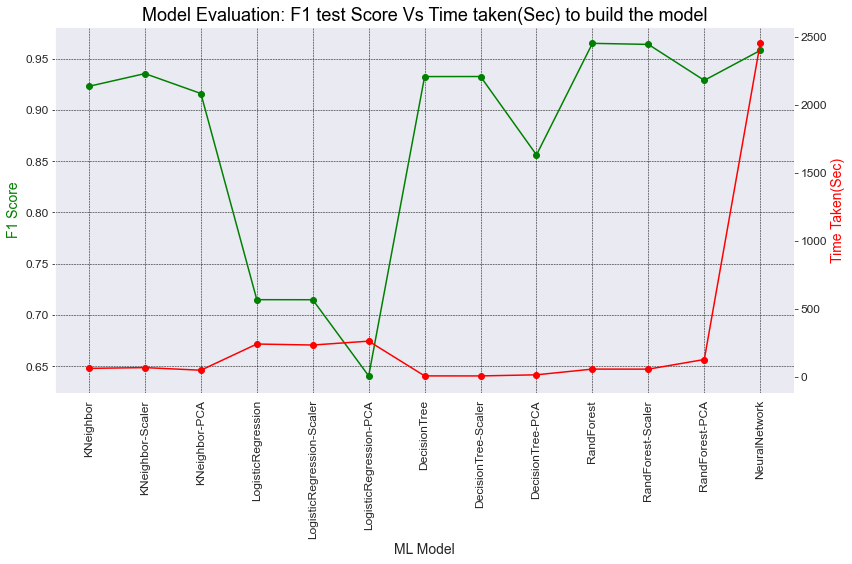

In [120]:
# create plot to compare f1 score and the time taken to build it
fig,ax = plt.subplots()
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
# set a plot size
plt.rcParams["figure.figsize"] = [12, 12]
plt.rcParams["figure.autolayout"] = True
# make the plot
ax.plot(plot_filtered.xLabel, plot_filtered.f1_score_test, color="green", marker="o")
# set x-axis label
ax.set_xlabel("ML Model",fontsize=14)
# set y-axis label
ax.set_ylabel("F1 Score",color="green",fontsize=14)
plt.xticks(rotation = 90) 
# twin object for 2nd y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(df_plot.xLabel, df_plot["f1_score_test"],color="red",marker="o")
ax2.plot(plot_filtered.xLabel, plot_filtered["time_taken"],color="red",marker="o")

ax2.set_ylabel("Time Taken(Sec)",color="red",fontsize=14)
ax2.set_title("Model Evaluation: F1 test Score Vs Time taken(Sec) to build the model",color="black",fontsize=18)

plt.show()


### Comparing The F1 Test Score and the time it took to build the model
* F1 Test Score
    * **RandomForest Classifier** With no further transformation Gave us the best score of **97%** and took 57.5 sec
    
* Time Taken
    * **Decision trees** took only 7.3 seconds and the model had **93%** F1 test score

Text(0, 0.5, 'F1 Score')

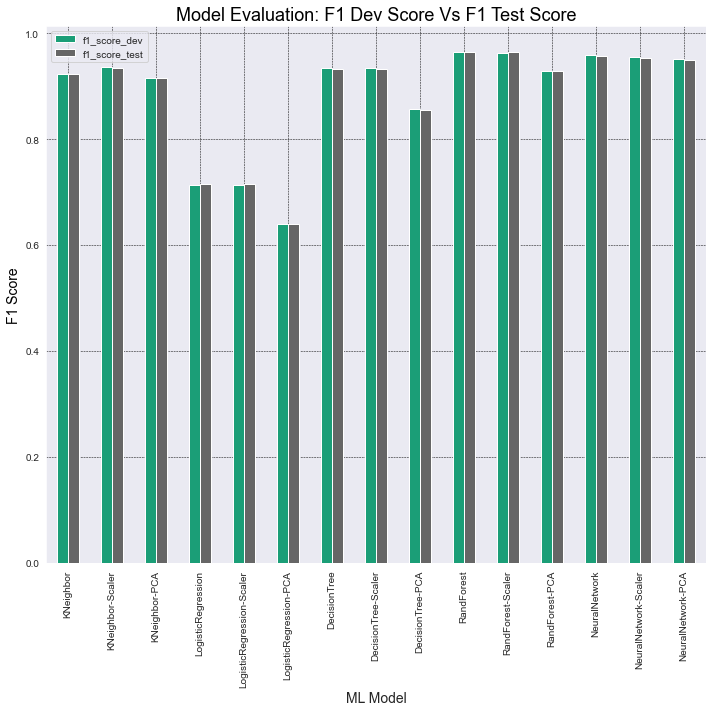

In [63]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

df_plot.plot( kind='bar'
            ,x = 'xLabel'
            ,y = ["f1_score_dev", "f1_score_test"]
            ,colormap='Dark2')
sns.set_style("dark")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)

plt.title("Model Evaluation: F1 Dev Score Vs F1 Test Score",color="black",fontsize=18)
plt.xlabel("ML Model",fontsize=14)
plt.ylabel("F1 Score",color="black",fontsize=14)

##  Confusion Matrix
#### Performance of our classification model on the set of test data
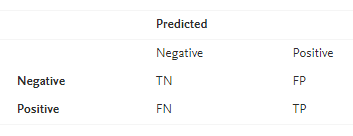

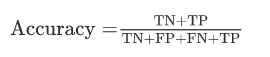

In [64]:
Tree_Labels = ["Spuce/Fir",
                "Lodgepole Pine",
                "Ponderosa Pine",
                "Cottonwood/Willow",
                "Aspen",
                "Douglas-fir",
                "Krummholz"]

In [66]:
# Get the record with the highest F1 Score
df_sorted_Highest_f1 = df_sorted.sort_values(by='f1_score_test', ascending=False)
df_sorted_Highest_f1.iloc[0]

model_name                                   RandomForestClassifier
model_type                                                     None
time_taken                                                57.511182
f1_score_dev                                               0.964096
f1_score_test                                              0.964882
predicted_dev     [1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, ...
predicted_test    [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, ...
xLabel                                                   RandForest
Name: 9, dtype: object

In [ ]:
df_sorted_Highest_f1

Text(0, 0.5, 'Actual Labels')

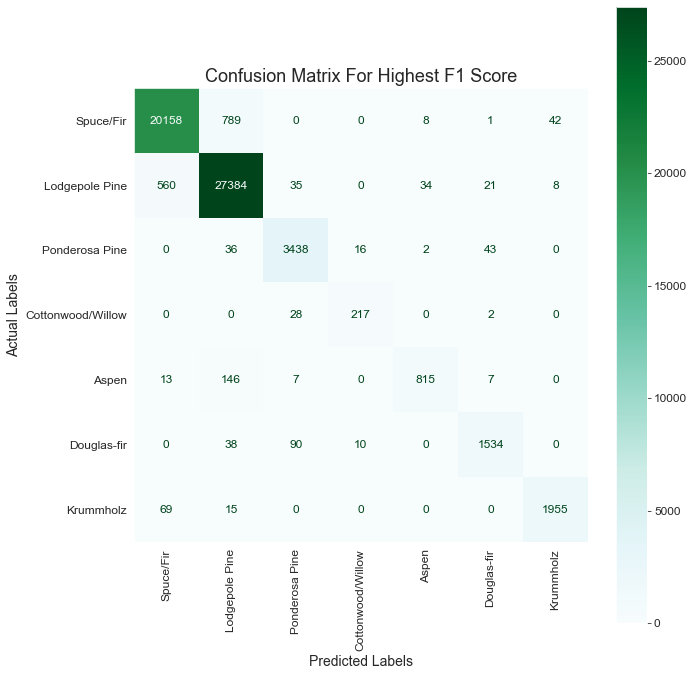

In [121]:
conf_matrix = metrics.confusion_matrix(test_labels,df_sorted_Highest_f1.iloc[0]["predicted_test"])
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 12})

cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=Tree_Labels)
cmd.plot(cmap = 'BuGn',xticks_rotation='vertical', values_format = 'd')
cmd.ax_.set_title('Confusion Matrix For Highest F1 Score', fontsize=18)
cmd.ax_.set_xlabel('Predicted Labels', fontsize=14)
cmd.ax_.set_ylabel('Actual Labels', fontsize=14)

## Confusion Matrix for the best scoring model

* The two most confused tree types were **Spuce/Fir** and **Lodgepole Pine** for Random Forest Model
* F1 Score **97%**
* **2%** of the times, our model identified Lodgepole Pine as Spuce/Fir
* **3.9%** of the times, our model identified Spuce/Fir as Lodgepole Pine

In [68]:
df_sorted_Least_time = df_plot.sort_values(by='time_taken', ascending=True)
df_sorted_Least_time.iloc[0]

model_name                                   DecisionTreeClassifier
model_type                                                   Scaler
time_taken                                                 7.329729
f1_score_dev                                               0.934288
f1_score_test                                              0.932529
predicted_dev     [1.0, 2.0, 3.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, ...
predicted_test    [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, ...
xLabel                                          DecisionTree-Scaler
Name: 7, dtype: object

Text(0, 0.5, 'Actual Labels')

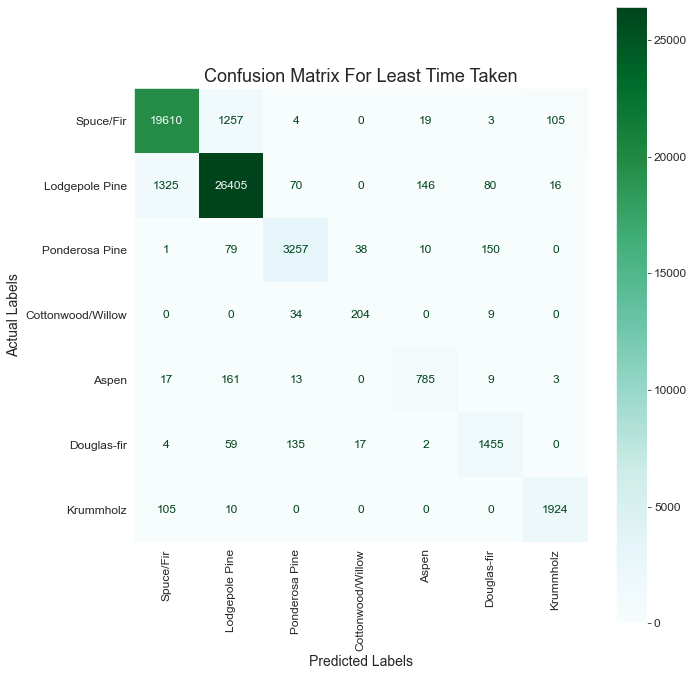

In [70]:
# Confusion Matrix for the model that took least time to build
conf_matrix = metrics.confusion_matrix(test_labels,df_sorted_Least_time.iloc[0]["predicted_test"])
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 12})
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=Tree_Labels)
cmd.plot(cmap = 'BuGn',xticks_rotation='vertical', values_format = 'd')
cmd.ax_.set_title('Confusion Matrix For Least Time Taken', fontsize=18)
cmd.ax_.set_xlabel('Predicted Labels', fontsize=14)
cmd.ax_.set_ylabel('Actual Labels', fontsize=14)

## Confusion Matrix for the fastest model

* The two most confused tree types were **Spuce/Fir** and **Lodgepole Pine** for the fastest model DecisionTree with MinMax Scaler Transformation
* F1 Score **93%**
* **5%** of the times, our model identified Lodgepole Pine as Spuce/Fir
* **6.4%** of the times, our model identified Spuce/Fir as Lodgepole Pine

In [71]:
# Model with Lowest F1 Score aka Least Accuracy
df_sorted_Highest_f1.iloc[-1]


model_name                                       LogisticRegression
model_type                                                      PCA
time_taken                                               263.004946
f1_score_dev                                               0.640204
f1_score_test                                              0.640479
predicted_dev     [2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
predicted_test    [1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, ...
xLabel                                       LogisticRegression-PCA
Name: 5, dtype: object

Text(0, 0.5, 'Actual Labels')

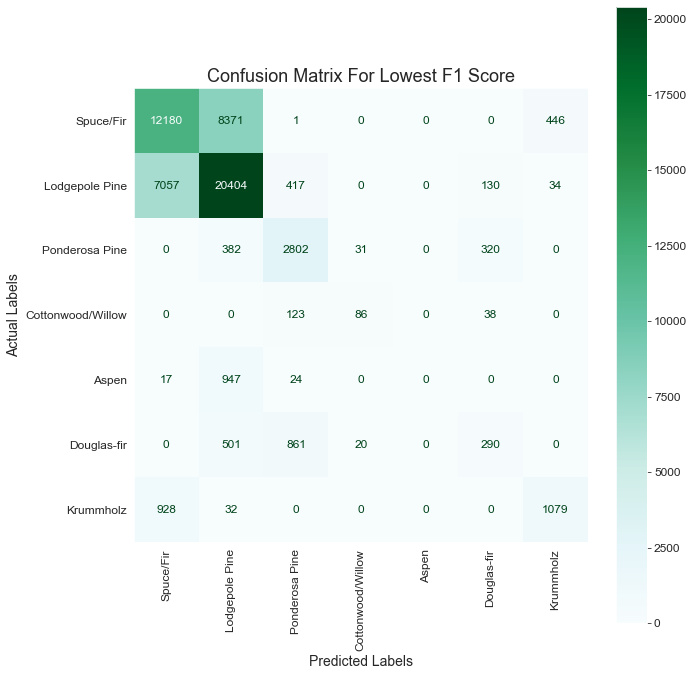

In [136]:
# Confusion matrix for model with Lowest F1 Score aka Least Accuracy
conf_matrix = metrics.confusion_matrix(test_labels,df_sorted_Highest_f1.iloc[-1]["predicted_test"])
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 12})

cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=Tree_Labels)
cmd.plot(cmap = 'BuGn',xticks_rotation='vertical', values_format = 'd')
cmd.ax_.set_title('Confusion Matrix For Lowest F1 Score', fontsize=18)
cmd.ax_.set_xlabel('Predicted Labels', fontsize=14)
cmd.ax_.set_ylabel('Actual Labels', fontsize=14)

## Confusion Matrix for the worst scoring model

* The two most confused tree types were **Spuce/Fir** and **Lodgepole Pine** for the worst scoring model LogisticRegression-PCA
* F1 Score **64%**
* **34.6%** of the times, our model identified Lodgepole Pine as Spuce/Fir
* **68.7%** of the times, our model identified Spuce/Fir as Lodgepole Pine

In [138]:
# The model that took maximum time to build
df_sorted_Least_time.iloc[-1]

model_name                                            NeuralNetwork
model_type                                                      PCA
time_taken                                             19306.877323
f1_score_dev                                               0.951671
f1_score_test                                               0.94941
predicted_dev     [1.0, 2.0, 3.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, ...
predicted_test    [2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, ...
xLabel                                            NeuralNetwork-PCA
Name: 14, dtype: object

Text(0, 0.5, 'Actual Labels')

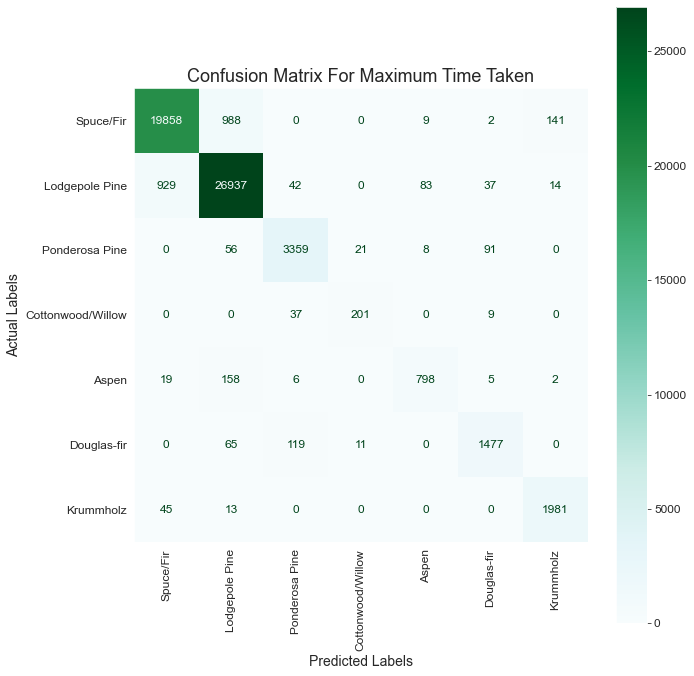

In [76]:
# Confusion Matrix for the model that took maximum time to build
conf_matrix = metrics.confusion_matrix(test_labels,df_sorted_Least_time.iloc[-1]["predicted_test"])
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 12})
cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=Tree_Labels)
cmd.plot(cmap = 'BuGn',xticks_rotation='vertical', values_format = 'd')
cmd.ax_.set_title('Confusion Matrix For Maximum Time Taken', fontsize=18)
cmd.ax_.set_xlabel('Predicted Labels', fontsize=14)
cmd.ax_.set_ylabel('Actual Labels', fontsize=14)


## Confusion Matrix for the slowest model

* The two most confused tree types were **Spuce/Fir** and **Lodgepole Pine** for the slowest model NeuralNetwork-PCA
* F1 Score **95%**
* **3.4%** of the times, our model identified Lodgepole Pine as Spuce/Fir
* **5%** of the times, our model identified Spuce/Fir as Lodgepole Pine

In [78]:
plot_filtered_best = df_plot[df_plot["xLabel"].isin( ["DecisionTree-Scaler","RandForest"])]

In [84]:
print("\033[1m" ,"\t\t\tBest Models (By Score and By Time)", "\033[0m" )
plot_filtered_best[['xLabel','f1_score_dev','f1_score_test','time_taken']]

 			Best Models (By Score and By Time) 


,xLabel,f1_score_dev,f1_score_test,time_taken
7,DecisionTree-Scaler,0.934288,0.932529,7.329729
9,RandForest,0.964096,0.964882,57.511182


Text(0.5, 0.98, 'Best F1 Test Score vs Fastest Build Time')

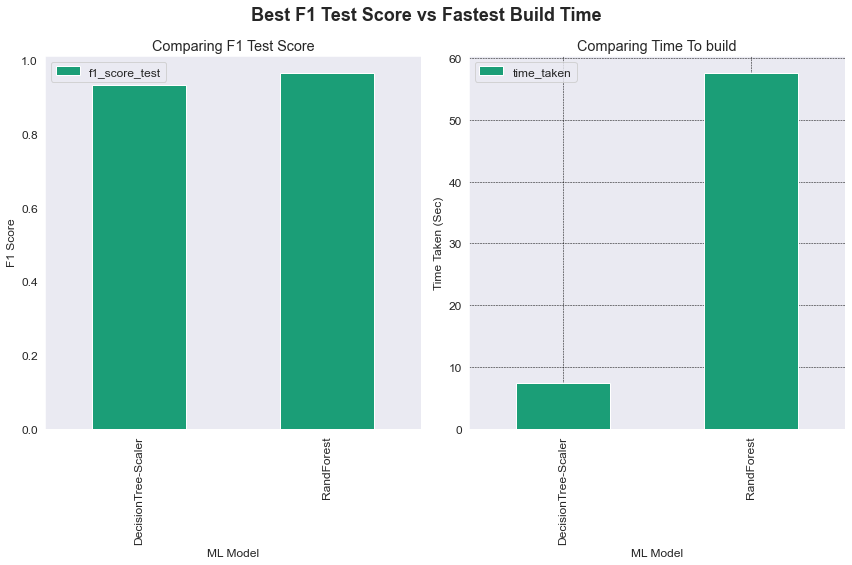

In [116]:
figure, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

plot_filtered_best.plot( ax=axes[0], kind='bar'
            ,x = 'xLabel'
            ,y = "f1_score_test"
            ,colormap='Dark2', title = "Comparing F1 Test Score", xlabel = "ML Model", ylabel = "F1 Score"  )
plot_filtered_best.plot( ax=axes[1], kind='bar'
            ,x = 'xLabel'
            ,y = "time_taken" 
            ,colormap='Dark2', title = "Comparing Time To build", xlabel = "ML Model", ylabel = "Time Taken (Sec)")
sns.set_style("dark")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
figure.suptitle('Best F1 Test Score vs Fastest Build Time',fontsize=18,fontweight ="bold")


## Classification Report
##### Measure the quality of predictions for our classification algorithm.

###### Precision – Accuracy of positive predictions - (TP/(TP + FP))
###### Recall – What percent of the positive cases did our Model catch - TP/(TP+FN)
###### F1 score – What percent of positive predictions were correct - (2*(Recall * Precision) / (Recall + Precision))

In [117]:
print ( "\033[1m" , "Classification Report of the Model with the best F1 Test Score" , "\033[0;0m" )
print(metrics.classification_report(df_sorted_Highest_f1.iloc[0]["predicted_test"],test_labels ))

 Classification Report of the Model with the best F1 Test Score 
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.96     20800
         2.0       0.98      0.96      0.97     28408
         3.0       0.97      0.96      0.96      3598
         4.0       0.88      0.89      0.89       243
         5.0       0.82      0.95      0.88       859
         6.0       0.92      0.95      0.94      1608
         7.0       0.96      0.98      0.97      2005

    accuracy                           0.96     57521
   macro avg       0.93      0.95      0.94     57521
weighted avg       0.97      0.96      0.97     57521



* The Best model performed very well against test dataset
* **97%** of the times it classified the trees correctly

In [118]:
print ( "\033[1m" , "Classification Report of the Model that took Least Time" , "\033[0;0m" )
print(metrics.classification_report(df_sorted_Least_time.iloc[0]["predicted_test"],test_labels ))

 Classification Report of the Model that took Least Time 
              precision    recall  f1-score   support

         1.0       0.93      0.93      0.93     21062
         2.0       0.94      0.94      0.94     27971
         3.0       0.92      0.93      0.92      3513
         4.0       0.83      0.79      0.81       259
         5.0       0.79      0.82      0.81       962
         6.0       0.87      0.85      0.86      1706
         7.0       0.94      0.94      0.94      2048

    accuracy                           0.93     57521
   macro avg       0.89      0.89      0.89     57521
weighted avg       0.93      0.93      0.93     57521



* The Fastest model also performed well against the test dataset
* **93%** of the times it classified the trees correctly

## Answer to the questions identified earlier

#### Can we build a model that predicts what types of trees grow in an area based on the surrounding characteristics?

* Yes, With **97%** accuracy, using  *Random Forest classification algorithm* (consisting of many decisions trees), we can predict what types of trees grow in an area based on the surrounding characteristics

#### What kinds of trees are most common in the Roosevelt National Forest?
* In Roosevelt National Forest **Lodgepole Pine** are the most common type of tree followed by **Spuce/Fir** .

#### What tree types are confused most ?
* **Spuce/Fir**  and **Lodgepole Pine** are most often confused in all our classification models


# Conclusion:
#### Lessons learnt on the way

* Know your data
* EDA and Data wrangling is **Extreamly** important, The correctness of your model depends on how well do perform this
* Try different models, there are various paths to reach the destination
* Make changes to your model(s) iteratively
* Compare each iteration (Features, F1 score/ confusion matrix/classification report/ time)
* Correlation map is your friend
* Be aware of overfitting
* Have fun! 

# Thank You From Group 3!